In [2]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

/home/mxy/anaconda3/envs/pointe/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [4]:
import numpy as np
# 定义总参数量、可训练参数量及非可训练参数量变量
Total_params = 0
Trainable_params = 0
NonTrainable_params = 0

# 遍历model.parameters()返回的全局参数列表
for param in base_model.parameters():
    mulValue = np.prod(param.size())  # 使用numpy prod接口计算参数数组所有元素之积
    Total_params += mulValue  # 总参数量
    if param.requires_grad:
        Trainable_params += mulValue  # 可训练参数量
    else:
        NonTrainable_params += mulValue  # 非可训练参数量

print(f'Total params: {Total_params}')
print(f'Trainable params: {Trainable_params}')
print(f'Non-trainable params: {NonTrainable_params}')

# 遍历model.parameters()返回的全局参数列表
for param in upsampler_model.parameters():
    mulValue = np.prod(param.size())  # 使用numpy prod接口计算参数数组所有元素之积
    Total_params += mulValue  # 总参数量
    if param.requires_grad:
        Trainable_params += mulValue  # 可训练参数量
    else:
        NonTrainable_params += mulValue  # 非可训练参数量

print(f'Total params: {Total_params}')
print(f'Trainable params: {Trainable_params}')
print(f'Non-trainable params: {NonTrainable_params}')

Total params: 40333836
Trainable params: 40333836
Non-trainable params: 0
Total params: 80804376
Trainable params: 80804376
Non-trainable params: 0


In [5]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [6]:
# Set a prompt to condition on.
prompt = 'a brave girl'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

130it [00:15,  8.37it/s]


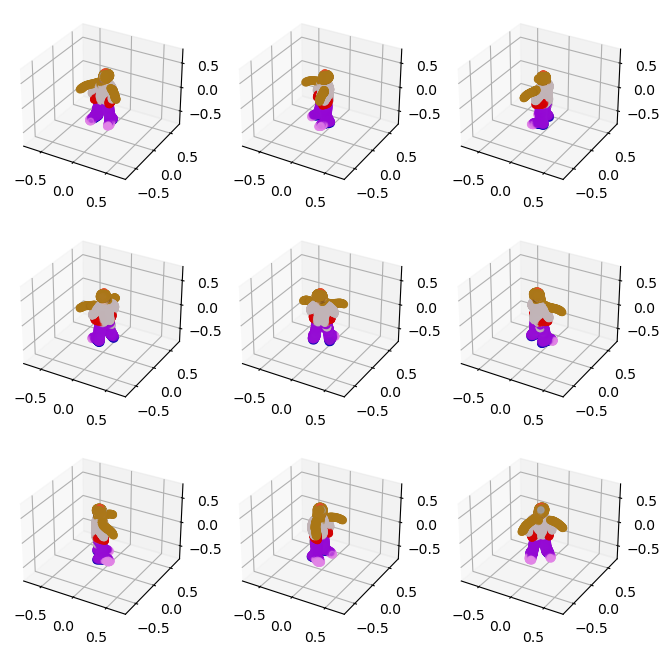

In [7]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))